# Behavioral Data Analysis

This Jupyter Notebook organizes and visualizes behavioral data using Python. It includes raster plots, d-prime analysis, learning licks analysis, response time analysis, performance boxplots, and Monte Carlo simulations.

## **Setup**
First, we import the necessary libraries and helper functions.


In [2]:
# Import required modules and custom functions
from Mouse_Data import Mouse_Data
from helpers import *
from visualization import *

import os
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

matplotlib.rcParams.update({'font.size':16, 'font.family':'Times New Roman', 
                            'axes.facecolor':'white' , 'figure.facecolor':'white', 'figure.dpi':100})

# Define root data path
root = 'D:/mStim_data/'

## **Load Data**
We initialize the `Mouse_Data` object, which will be used throughout the analysis.


In [ ]:
# Load Mouse Data
dataPath = root + 'VPS34/SNA-141498/'
mouse = Mouse_Data(dataPath)

# Visualize data and save plots
* Raster Plot 
* D prime (session and trial)
* Lick raster hit and FP
* Response time 
* Hit Percentage

Saving to: D:\mStim_data\VPS34\SNA-141498\analysis\performance_barplot


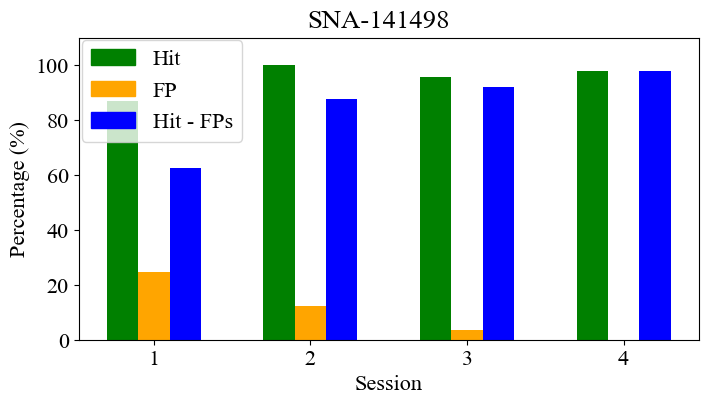

Saving to: D:\mStim_data\VPS34\SNA-141498\analysis\raster
Saving to: D:\mStim_data\VPS34\SNA-141498\analysis\dprime_session


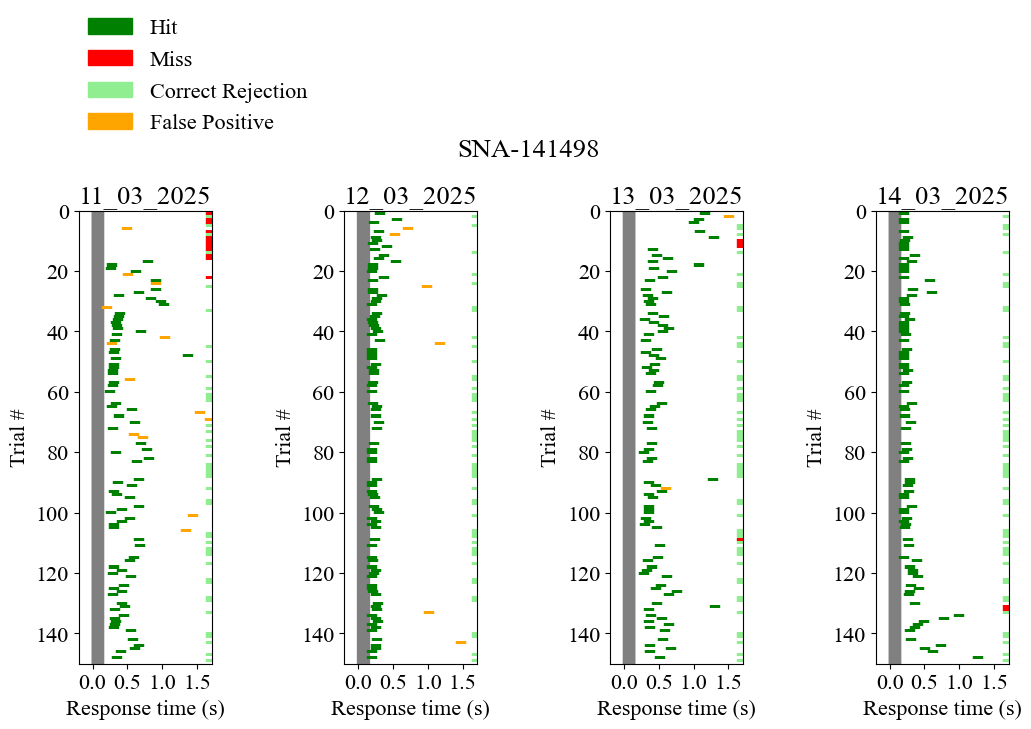

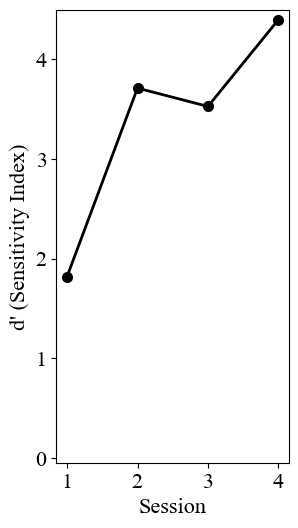

Saving to: D:\mStim_data\VPS34\SNA-141498\analysis\lick_performance


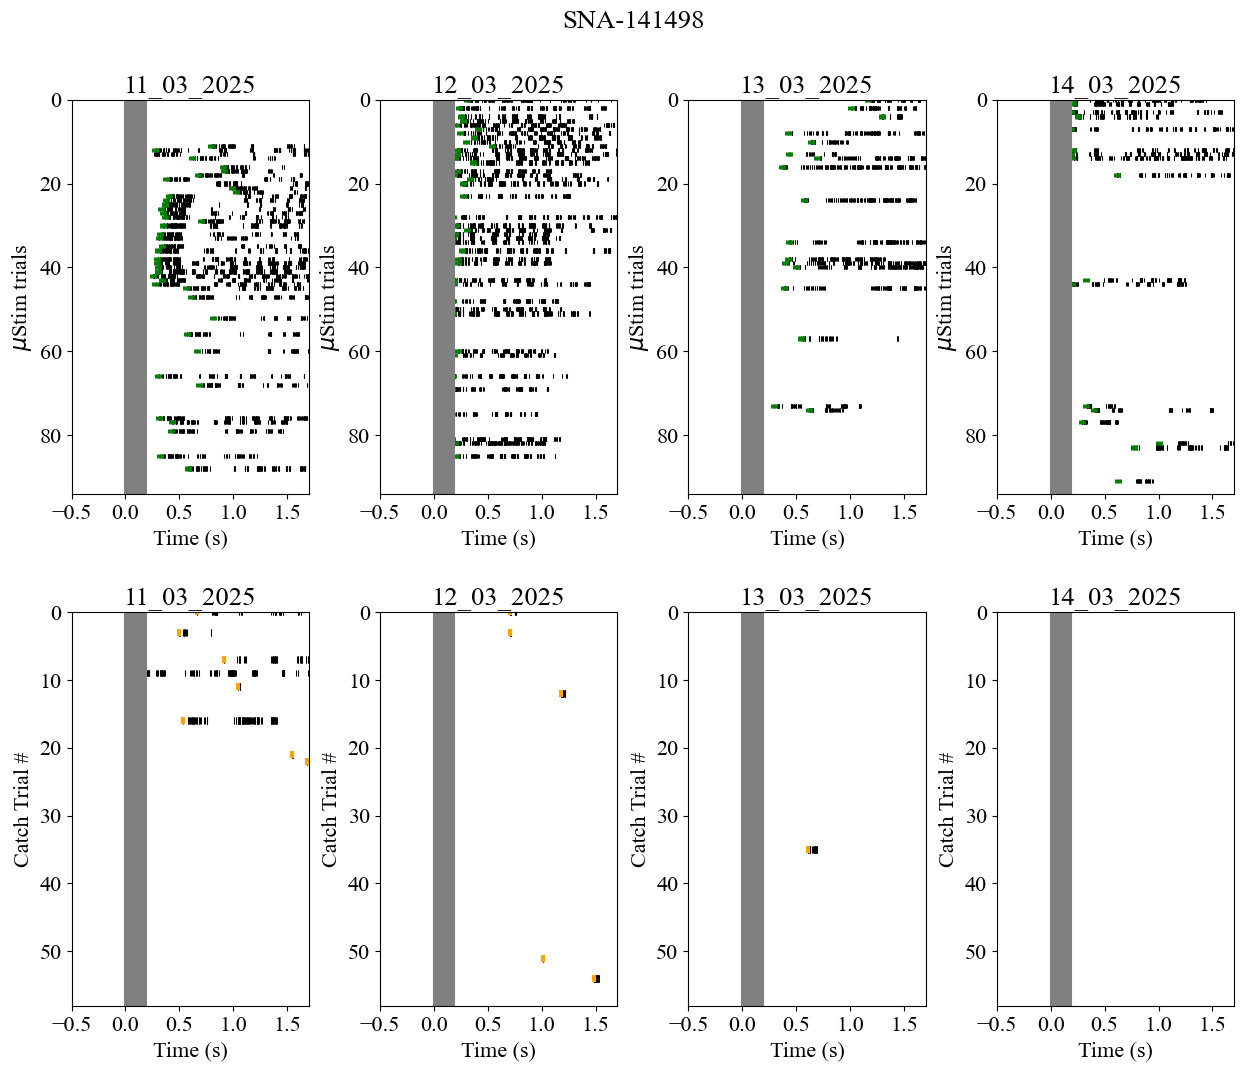

Saving to: D:\mStim_data\VPS34\SNA-141498\analysis\P_Lick


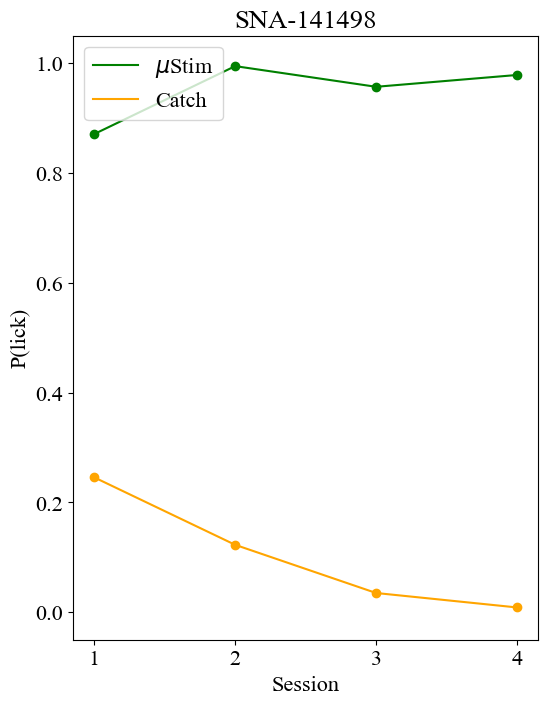

Saving to: D:\mStim_data\VPS34\SNA-141498\analysis\RT_session


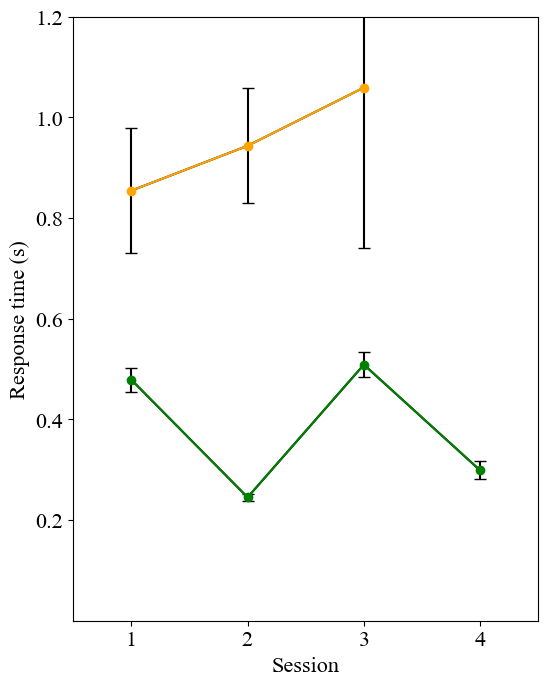

In [ ]:
# INDIVIDUAL PLOTS
savePath = dataPath + 'analysis/'
plot_performance(mouse, save=savePath + 'performance_barplot')
plot_raster_rt(mouse, save=savePath + 'raster')
plot_d_prime(mouse, save=savePath + 'dprime_session')
plot_lickPerformance(mouse, save=savePath + 'lick_performance')
plot_Plick(mouse, save=savePath+'P_Lick')
plot_RT(mouse, savePath+'RT_session')
plot_FLicks(mouse, savePath+'FLick_final') # TODO onlt plots the final session, is that alright?
plot_falsePositives(mouse) # TODO save


Saving to: F:\mStim_data\DELTA\ANM560981\analysis\FLick_final


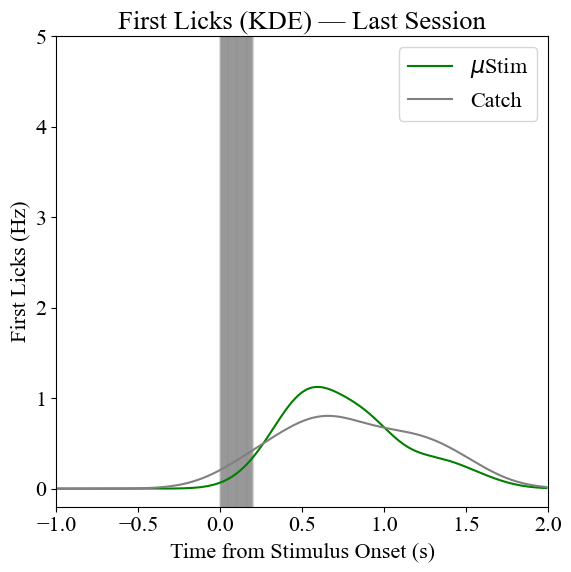

Saving to: F:\mStim_data\DELTA\ANM560982\analysis\FLick_final


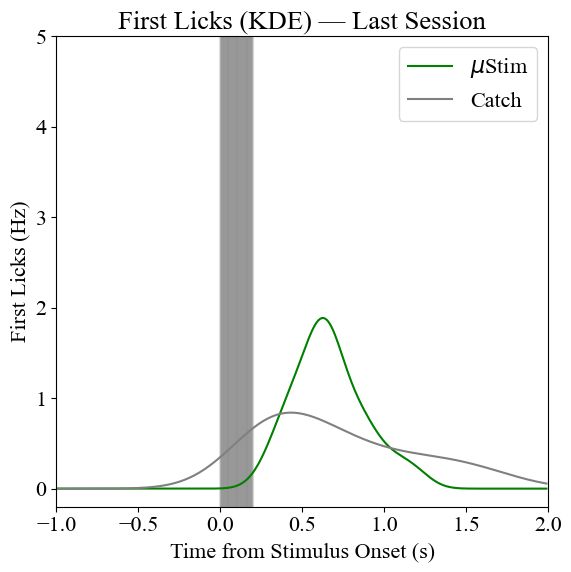

Saving to: F:\mStim_data\DELTA\ANM562423\analysis\FLick_final


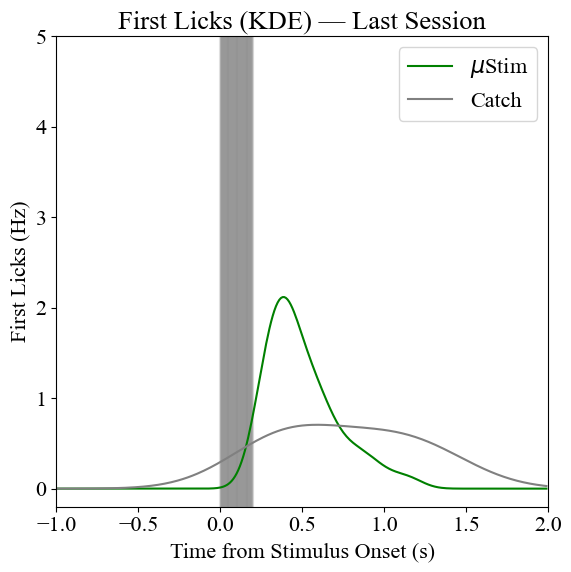

Saving to: F:\mStim_data\DELTA\ANM562424\analysis\FLick_final


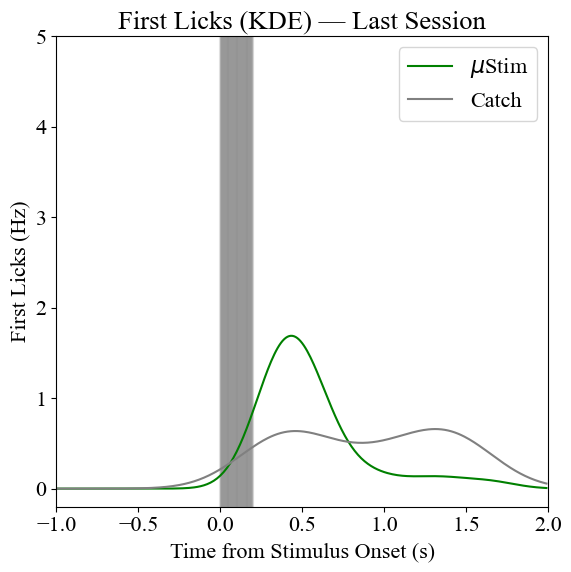

Saving to: F:\mStim_data\DELTA\ANM562425\analysis\FLick_final


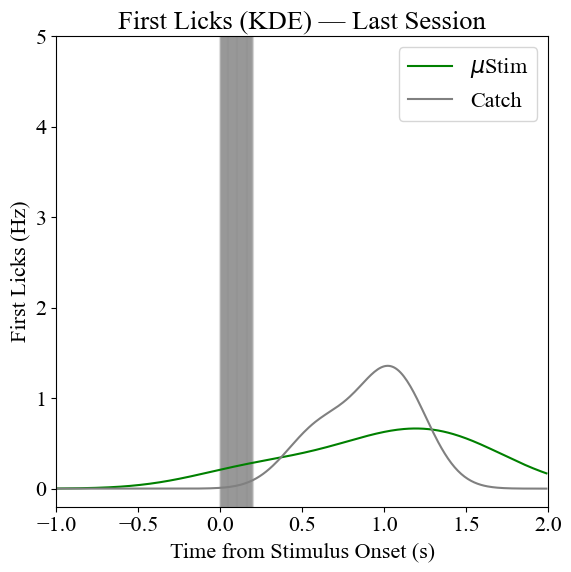

Data will be concatenated; please check validity.
Saving to: F:\mStim_data\DELTA\ANM564018\analysis\FLick_final


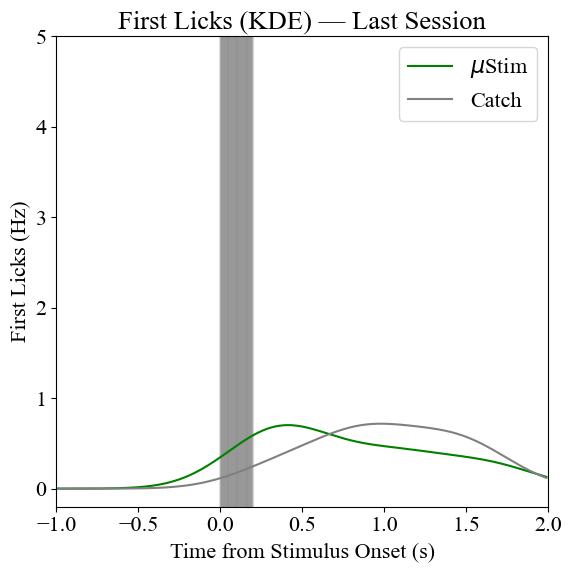

Saving to: F:\mStim_data\DELTA\ANM564019\analysis\FLick_final


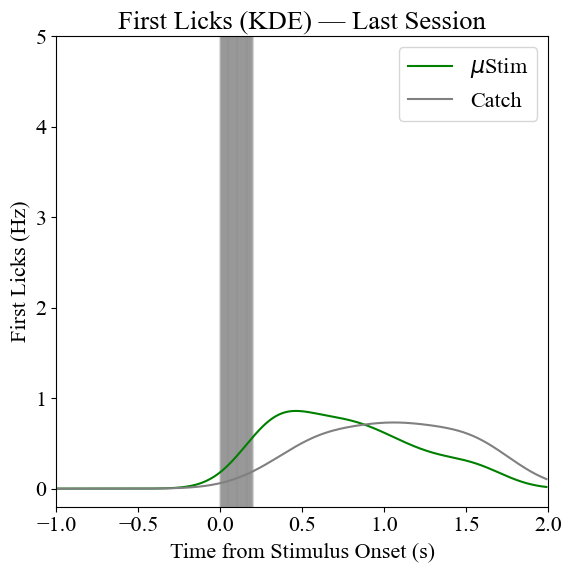

Saving to: F:\mStim_data\DELTA\ANM564244\analysis\FLick_final


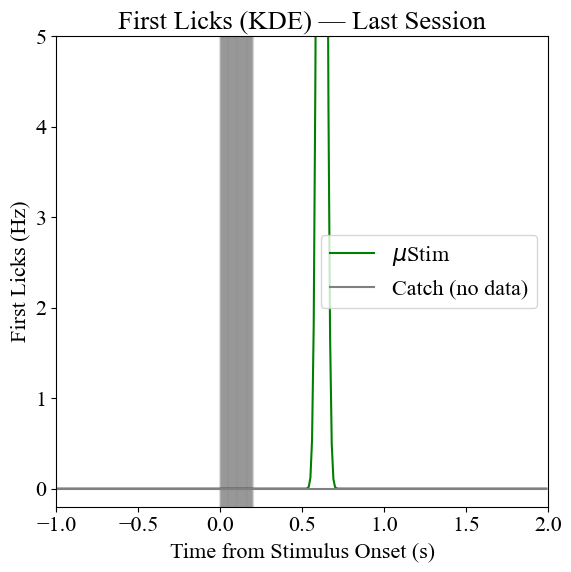

Saving to: F:\mStim_data\DELTA\ANM564245\analysis\FLick_final


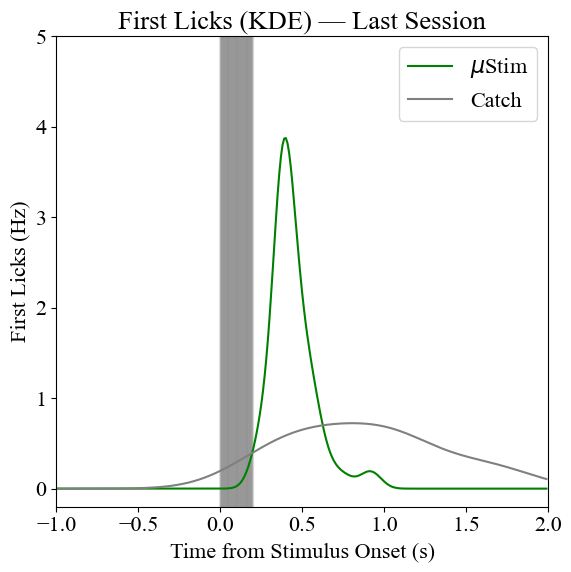

Data will be concatenated; please check validity.
Saving to: F:\mStim_data\DELTA\ANM564246\analysis\FLick_final


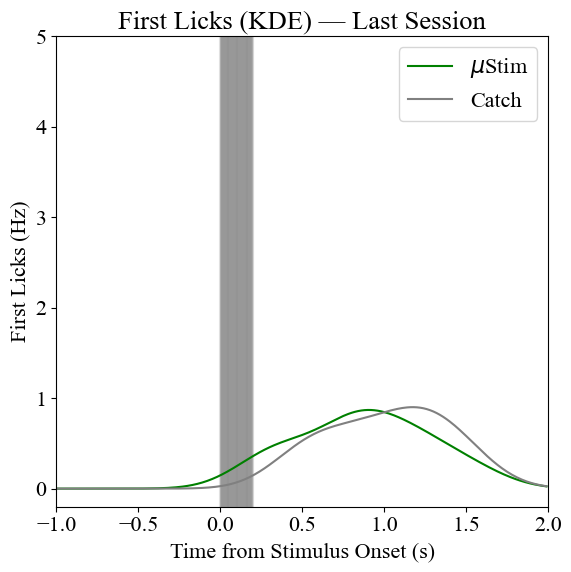

Saving to: F:\mStim_data\DELTA\ANM566578\analysis\FLick_final


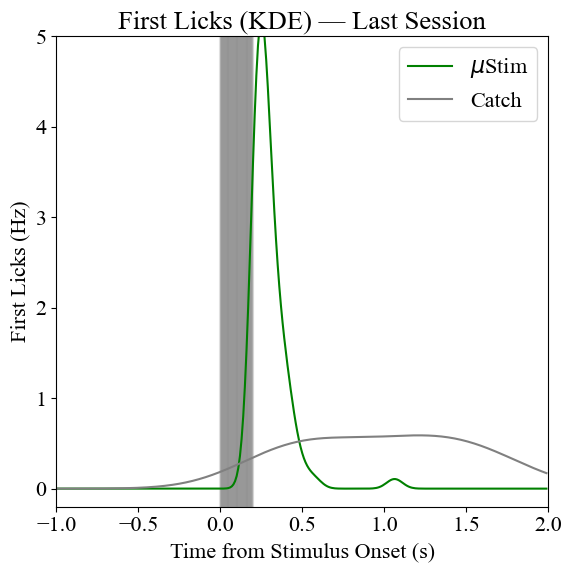

Data will be concatenated; please check validity.
Saving to: F:\mStim_data\DELTA\ANM566579\analysis\FLick_final


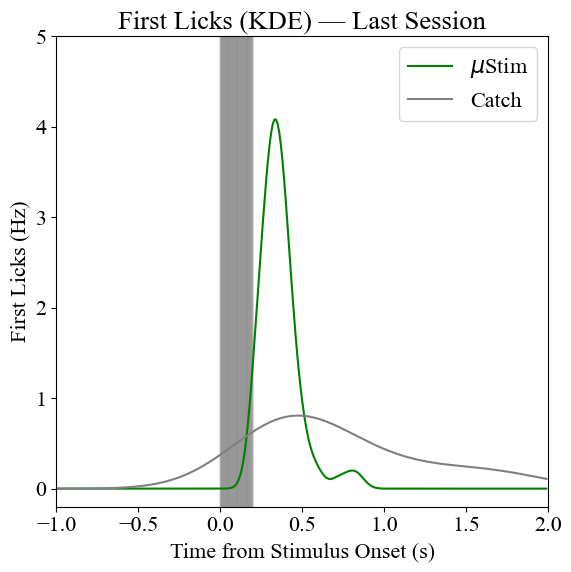

In [ ]:
# LOOP PLOTS
# Load Mouse Data
root = 'F:/mStim_data/DELTA/'
IDs = os.listdir(root)




for ID in IDs:
    dataPath = root + ID + '/'
    mouse = Mouse_Data(dataPath)
    savePath = dataPath + 'analysis/'

    # Plot
    # plot_performance(mouse, save=savePath + 'performance_barplot')
    # plot_raster_rt(mouse, save=savePath + 'raster')
    # plot_d_prime(mouse, save=savePath + 'dprime_session')
    # plot_lickPerformance(mouse, save=savePath + 'lick_performance')
    # plot_Plick(mouse, save=savePath+'P_Lick')
    # plot_RT(mouse, savePath+'RT_session')
    # plot_FLicks(mouse, savePath+'FLick_final') # TODO onlt plots the final session. Catch is gray and not orange 



# Determine learning moment
Steps:


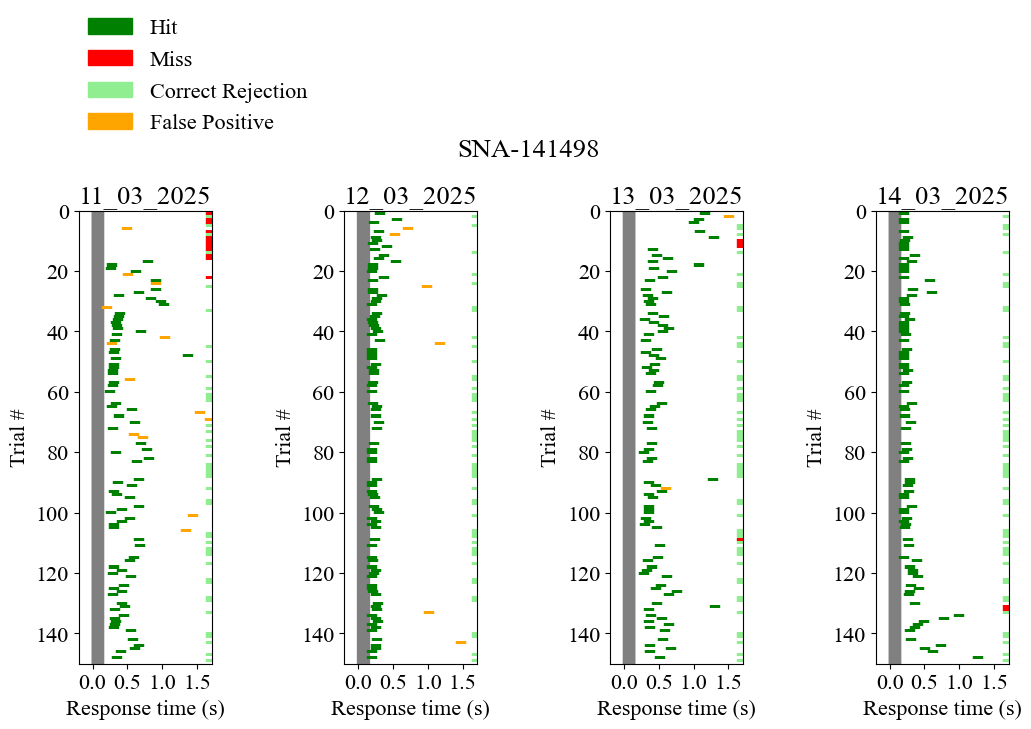

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


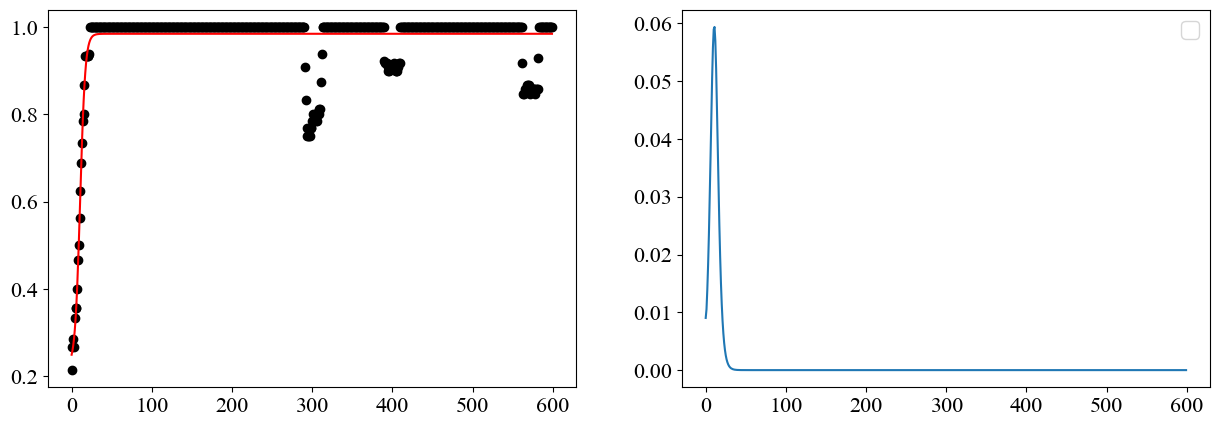

In [ ]:
# Show the most informative plot:
plot_raster_rt(mouse)

# Calculate the metrics we use for determining the Eureka moment
binsize = 20
Plick, _ = get_PLick(mouse, binsize=binsize) # mStim_Plick only contains microstim trials
d_prime = calc_d_prime(mouse, binsize=binsize) # Contains all trials
RTs = get_RT(mouse.full_data, 1, binsize=binsize) # Contains only hit trials
sem = get_SEM(RTs, binsize=binsize) # Contains only hit trials


# Plot the raw PLick and a fitted sigmoid
x_data = np.arange(0, len(Plick), 1)
y_data = Plick

# Define the sigmoidal function (logistic function)
# TODO is this actually necessary?
def sigmoid(x, L, x0, k, b):
    return L / (1 + np.exp(-k * (x - x0))) + b
popt, pcov = curve_fit(sigmoid, x_data, y_data, p0=[1, 5, 1, 0])

# Plot the original data and the fitted sigmoidal function
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.scatter(x_data, y_data, label='Data', color='black') # Original
ax1.plot(x_data, sigmoid(x_data, *popt), label='Fitted sigmoid', color='red') # Fitted


# TODO get this derivative as well as any derivative of the other metrics and determine where it is highest
# Also get the derivative, indicating the speed of change. This should be highest at the moment of learning.
der = np.gradient(sigmoid(x_data, *popt))
peak_idx = np.argmax(der)
ax2.plot(der)
plt.legend()
plt.show()

## **Monte Carlo Simulation**
This section runs a Monte Carlo simulation to estimate the probability of early learning.


In [ ]:
def Monte_Carlo(sample, threshold, num_simulations=100000, save=False, save_path='.'):
    simulation_results = [np.mean(np.random.choice(sample, size=100, replace=True) <= threshold) for _ in range(num_simulations)]
    probability = np.mean(simulation_results)

    fig, ax = plt.subplots(figsize=(7,4))
    plt.hist(simulation_results, bins=40, density=True, alpha=0.7, color='blue', label='Random')
    plt.xlabel('Proportion of Animals Learned within first 30 trials')
    plt.ylabel('Frequency')
    plt.legend(loc='upper right')
    plt.show()

    if save:
        fig.savefig(f"{save_path}/MonteCarlo.png", dpi=300)

    return probability

start_threshold = 30
prob = Monte_Carlo([150, 30, 10, 45, 150, 40, 10, 10, 70, 30], start_threshold, save=True, save_path='.')
